<img src="./01/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" />

# Cold plate and pipes
 
*Written by Marc Budinger and Yann Bocquet, INSA Toulouse, France*

The power module a fixed on a cold plate in order to cool it. This cold plat is connected to the heat exchanger thanks pipes. 
The selection of the components requires to be able to calculate the pressure drops according to the flow.

## 1. Coolant

The coolant considered is a [53% water-47% propylene glycol mix](https://doc.modelica.org/Modelica%203.2.3/Resources/helpDymola/Modelica_Media_Incompressible_Examples_Glycol47.html). <br>
We assume here that the average temperature of the coolant in the pipes is around 40°C.
As the maximum flow rate that cold plates can support is around 30 l/min (based on manufacturers catalog), we only consider flow rates between 0 and 30 l/min.   

In [3]:
import math as m
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt 

π = m.pi

'''Coolant flow characteristics (40°C)'''
λ_c  = 0.393              #[W/m.K] thermal conductivity
ρ_c  = 1030               #[kg/m3] density
cp_c = 3690               #[J/Kg.K] heat mass capacity
μ_c  = 0.00299            #[Pa.s] dynamic viscosity
dvmin  = 1                #[l/min] minimum flow rate 
dvmax  = 30               #[l/min] maximum flow rate 
n = 2000     # number of points
dvc  = np.linspace(dvmin, dvmax, n)  #[l/min] flow rate
dv_c = dvc/(1000*60)      #[m3/s] flow rate
dm_c = dv_c*ρ_c

## 2. Pipes

#### 2.1 Vehicle pipe network

Modeling assumption:
- We have chosen as reference diameter and total lenght of the pipe (between components), the values given in this [study](https://ideaexchange.uakron.edu/cgi/viewcontent.cgi?article=1143&context=honors_research_projects). <br>
- We assume that there are about 15 bends of 90°.  <br>
- We consider that there are about 5 enlargements and 5 restrictions.
- We assume that there is no elevation difference and junctions

In [4]:
L_pipes   = 1.2          #[m] total length of the pipe
D_pipes   = 15.9e-3      #[m] pipes diameter
A_pipes   = π*D_pipes**2/4     #[m²] pipes section
#Bends
n_bends  = 15           #[] number of bends  
#Connections
n_enla   = 5           #[] number of enlargements 
n_rest   = 5           #[] number of restrictions 

Re_c = dv_c*ρ_c*D_pipes/(A_pipes*μ_c)

##### 2.2 Pipes pressure drop 
Analytical solutions are not available for the majority of real fluids problems, experimental work and dimensional analysis enable to set up empirical laws. A description of the approach can be found [here]((https://ecourses.ou.edu/cgi-bin/eBook.cgi?doc=&topic=fl&chap_sec=06.1&page=theory) to relate the head loss, or pressure loss, due to friction along a given length of pipe to the average velocity of the fluid flow for an incompressible fluid.

In the pipes networks, the main pressure drops are:  
- **Linear pressure drop** : We use the [Darcy–Weisbach equation](https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation) $\Delta P=f_D\frac{L}{D_h}\rho \frac{v^2}{2}$ with $L$, $D_h$ and $v$ the length of the pipe, the hydraulic diameter and the velocity of the flow. <br>
The computation of the coefficient $f_D$ depends on the flow regime and the pipe type. 
    - if Re<2500 : $f_D=\frac{64}{Re}$
    - if Re>2500 : $f_D=\frac{0.3164}{Re^{0.25}}$ (smooth pipe)  

- **Singular pressure drop** : we use the equation $\Delta P=\zeta \rho \frac{v^2}{2}$ with $\zeta$ a coefficient depending on the pipe diameter and roughness and the curvature of the bend. The value of $\zeta$ is taken from [abacus](https://www.lycee-champollion.fr/IMG/pdf/pertes_de_charge.pdf). We assume the bends standard i.e. $R/D=2.5$.

*Notation*:  
- [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number) $R_e=\frac{\rho Vd}{\mu}$   
-$ΔP/L$ the linear pressure drop (Pa/m)  
-$ρ$ the density of the fluid (kg/m3)  
-$d$ the hydraulic diameter of the pipe (m)  
-$V$ the mean flow velocity (m/s)  
-$μ$ the dynamic viscosity of the fluid (Pa·s = N·s/m2 = kg/(m·s)).  


*Moody Diagram*

<img src="05/MoodyDiagram.png" width="600">

With these relations we can calculate:
- The Reynolds number evolution:

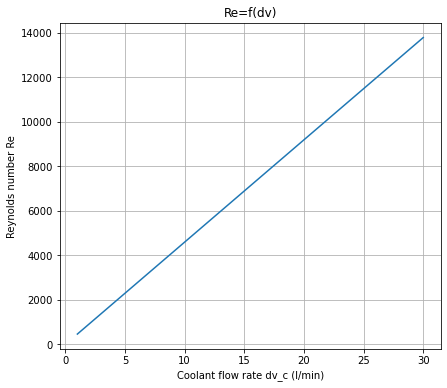

In [5]:
#Plot Reynolds number 
figure = plt.figure(figsize = (15, 6))
fig = figure.add_subplot(1, 2, 1)
fig.plot(dvc, Re_c)
fig.set_ylabel('Reynolds number Re')
fig.set_xlabel('Coolant flow rate dv_c (l/min)')
fig.set_title('Re=f(dv)')
fig.grid()

- The global pressure drop in the pipes, bends and connections:

- Linear pressure drop : dP_l ∈ [38, 7196] Pa
- Singular pressure drop :
	 o Bends : dP_bend ∈ [82, 73479] Pa
	 o Connections : dP_con ∈ [27, 24493] Pa
- Total pressure drop : dP_tot ∈ [147, 105168] Pa


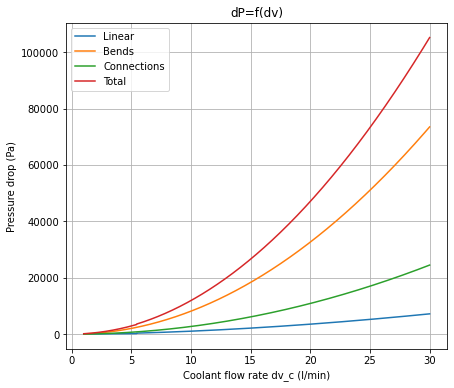

In [6]:
'''Linear pressure losses'''
Re_turb = 2500

fd = []
for Re in Re_c :
    if Re < Re_turb :     #Laminar
        fd = np.append(fd, 64/Re)
    else :                #Turbulent
        fd = np.append(fd, 0.3164/Re**(0.25))   
        
v    = dv_c/A_pipes                  #[m/s] coolant flow velocity
dP_l = fd*L_pipes*ρ_c*v**2/(2*D_pipes)     #[Pa] linear pressure losses    

'''Singular pressure losses'''
v = dv_c/A_pipes                     #[m/s] coolant velocity
#Bends
ζ_bend   = 1.5                      #[] ζ for 90° bends - R/D=2.5 
dP_bend  = 0.5*ρ_c*v**2*ζ_bend      #[Pa] pressure drop for 1 bend 
dP_bends = n_bends*dP_bend          #[Pa] pressure drop for all bends 
#Connections
ζ_enlar  = 1                        #[] ζ for an enlargement 
ζ_restr  = 0.5                      #[] ζ for a restriction 
dP_cons  = n_enla*0.5*ρ_c*v**2*ζ_enlar+ n_rest*0.5*ρ_c*v**2*ζ_restr     #[Pa] pressure drop for all connections
#Total
dP_tot  = dP_l+dP_bends+dP_cons     #[Pa] total pressure losses

print("- Linear pressure drop : dP_l ∈ [%0.0f, %0.0f] Pa" %(dP_l[0], dP_l[n-1]))
print("- Singular pressure drop :")
print("\t o Bends : dP_bend ∈ [%0.0f, %0.0f] Pa" %(dP_bends[0], dP_bends[n-1]))
print("\t o Connections : dP_con ∈ [%0.0f, %0.0f] Pa" %(dP_cons[0], dP_cons[n-1]))
print("- Total pressure drop : dP_tot ∈ [%0.0f, %0.0f] Pa" %(dP_tot[0], dP_tot[n-1]))

#Plot pressure drop
figure = plt.figure(figsize = (15, 6))
fig = figure.add_subplot(1, 2, 1)
fig.plot(dvc, dP_l, dvc, dP_bends, dvc, dP_cons, dvc, dP_tot)
fig.set_ylabel('Pressure drop (Pa)')
fig.set_xlabel('Coolant flow rate dv_c (l/min)')
fig.set_title('dP=f(dv)')
fig.legend(('Linear','Bends','Connections','Total'))
fig.grid()

#Find when flow starts to become turbulent
for i in range(n) :
    if Re_c[i] > Re_turb :    
        i_turb = i
        break

#### 2.3. Pressure drop in Modelica 

In Modelica simulations, the coolant pressure drop is computed with a slightly different method. It is computed from the nominal value and the ratio between $\dot{m}_{nominal}$ and $\dot{m}$:
- $dP=dP_{nominal}\Big(\frac{\dot{m}}{\dot{m}_{nominal}}\Big)^\alpha$

The $\alpha$ coefficient was chosen equal to 2 as only the linear pressure drop evolves with a different power coefficient (1 for laminar regime and 1.75 for turbulent regime) and because linear pressure losses are non predominant. We can see below that the relative error between the two models is small.

In order to minimize discrepancies between the two models, we choose as nominal point the border between laminar and turbulent regimes.

Limit laminar/turbulent :
dm_nom = 0.093 kg/s (dv = 5.4 l/min) --> dP = 3583 Pa

dm = 0.017 kg/s (dv = 1.0 l/min) --> dP = 121 Pa
dm = 0.266 kg/s (dv = 15.5 l/min) --> dP = 29124 Pa
dm = 0.515 kg/s (dv = 30.0 l/min) --> dP = 108999 Pa


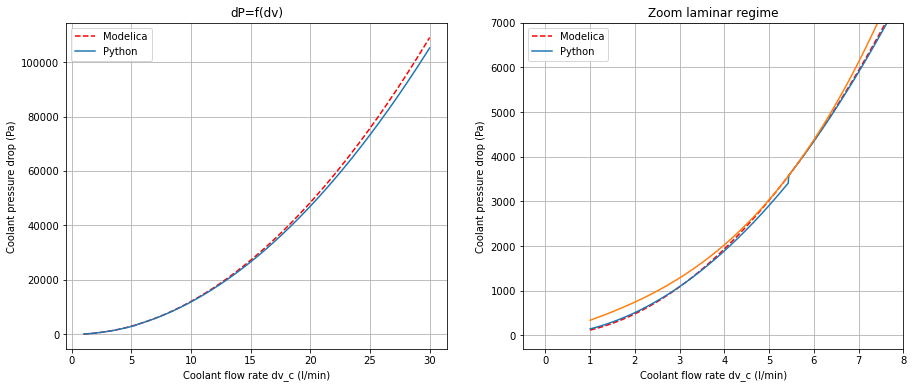

In [7]:
dm_c_nom = dm_c[i_turb]
dP_nom   = dP_tot[i_turb]
dP = dP_nom*(dm_c/dm_c_nom)**(2)

dP = dP_nom*(dm_c/dm_c_nom)**(2)
dP2 = dP_nom*(dm_c/dm_c_nom)**(2)*((dm_c_nom**2/dm_c+dm_c)/(2*dm_c_nom))

    
#Plot pressure drop 
figure = plt.figure(figsize = (15, 6))
fig = figure.add_subplot(1, 2, 1)
fig.plot(dvc, dP, 'r--', dvc, dP_tot)
fig.set_ylabel('Coolant pressure drop (Pa)')
fig.set_xlabel('Coolant flow rate dv_c (l/min)')
fig.legend(('Modelica','Python'))
fig.set_title('dP=f(dv)')
fig.grid()

fig = figure.add_subplot(1, 2, 2)
fig.plot(dvc, dP, 'r--', dvc, dP_tot, dvc, dP2)
fig.set_ylabel('Coolant pressure drop (Pa)')
fig.set_xlabel('Coolant flow rate dv_c (l/min)')
fig.legend(('Modelica','Python'))
fig.set_title('Zoom laminar regime')
plt.axis([-0.5, 8, -300, 7000])
fig.grid()

print("Limit laminar/turbulent :")
print("dm_nom = %0.3f kg/s (dv = %0.1f l/min) --> dP = %0.0f Pa" %(dm_c_nom, dm_c_nom/ρ_c*1000*60, dP_nom))

print("\ndm = %0.3f kg/s (dv = %0.1f l/min) --> dP = %0.0f Pa" %(dm_c[0], dm_c[0]/ρ_c*1000*60, dP[0]))
print("dm = %0.3f kg/s (dv = %0.1f l/min) --> dP = %0.0f Pa" %(dm_c[n//2], dm_c[n//2]/ρ_c*1000*60, dP[n//2]))
print("dm = %0.3f kg/s (dv = %0.1f l/min) --> dP = %0.0f Pa" %(dm_c[n-1], dm_c[n-1]/ρ_c*1000*60, dP[n-1]))

#### 2.4. Scaling modeling assumptions

> **Questions:** Is the diameter of the pipes a interesting design variable ? Propose a simplified model of pressure losses based on the previous calculations. 

**Answer:** The diameter of the pipe has a great influence on the pressure drop. The latter is mainly proportional to the square of the speed and therefore inversely proportional to the power of 4 of the diameter: 

$\Delta P^*=v^{*2}=d^{*-4}$

Analysis of [supplier documentation](https://www.steinbockgruppe.de/epages/64584549.sf/en_GB/?ViewObjectPath=%2FShops%2F64584549%2FProducts%2F%22SSH%20Verst%C3%A4rkter%20Silikonschlauch%22) shows that the thickness of the tubes is substantially constant. The working pressure changes significantly but still remains acceptable for our needs.  

Silicone Coolant Hose scaling laws:  
- Variable internal diameter: $D_{pipes,ref}=15.9 mm$
- Constante thickness: $t_{pipes,ref}=4.5 mm$ and $t^*=1$
- Lineic mass: $m_{l,pipes,ref}=0.25 kg/m$ and $m_{l,pipes}^*=D_{pipes}$
calculated with a density $\rho=1100 kg/m^3$

## 3. Cold plate with fins

Cold plates can have different forms: 
- with serpentine channel (figure 1) $\Longrightarrow$ general purpose cold plates
<img src="05/ColdPlate_Serpentine.JPG" width="300">

- with fins (figure 2) $\Longrightarrow$ power electronics cooling
<img src="05/ColdPlate_Fins.JPG" width="300">

Our models of cold plate will be based on the following reference with fins : [CP 3009 Microcool cold plate](https://www.microcooling.com/our-products/cold-plate-products/3000-series-cold-plates/cp-3009/)



In [8]:
'''Cold Plate Characteristics'''
L_plate = 227e-3            #[m] cold plate lenght 
W_plate = 160e-3            #[m] cold plate width 
e_plate = 10e-3             #[m] cold plate thickness
m_plate = 1.096             #[kg] cold plate mass

λ_alu   = 237                          #[W/m.K] thermal conductivity of aluminium
cp_alu  = 897                          #[J/K·kg] heat mass capacity of aluminium
ρ_alu   = 2.7e3                        #[kg/m3] density of aluminium


#### 3.1 Thermal Model of the Cold Plate
The cold plate is modeled as a thermal resistance and a capacity.

###### **3.1.1 Computation of the cold plate thermal resistance** 

The cold plate [datasheet](https://www.microcooling.com/wp-content/uploads/2015/05/CP3009-data-sheet.pdf) provides thermal resistance function of flow rate:

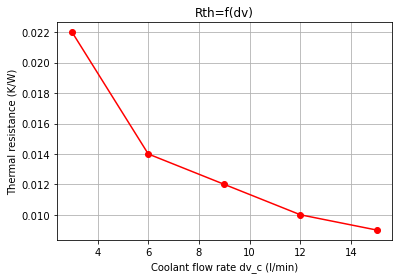

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data CP3009 Microcool
Rth_ref   = np.array([0.022, 0.014, 0.012, 0.010, 0.009])  #[K/W] Thermal resistance 
dvc_ref = np.array([3, 6, 9, 12, 15])                                  #[l/min] flow rate  
dv_c_ref = dvc_ref/(60*1000)                                          #[m3/s] flow rate

plt.plot(dvc_ref, Rth_ref, 'ro-')
plt.ylabel('Thermal resistance (K/W)')
plt.xlabel('Coolant flow rate dv_c (l/min)')
plt.title('Rth=f(dv)')
plt.grid()
plt.show()

> **Question:** We want to define a relation with the following form  
$R_{th}=R_{th_{nom}}\big(\frac{\dot{m}}{\dot{m}_{nom}}\big)^{\beta} \Longleftrightarrow R_{th}=C\dot{m}^{\beta}$ with $C$ a constant. <br>
Show how to use linear regression to define this equation.

**Answer:**  
This equation gives : $log(R_{th})=\beta log(\dot{m}) + log(C)$ <br>
Thus $\beta$ can be found with a linear regression between $log(R_{th})$ and $log(\dot{m})$. 

- β = -0.55
- C = 3.93E-02


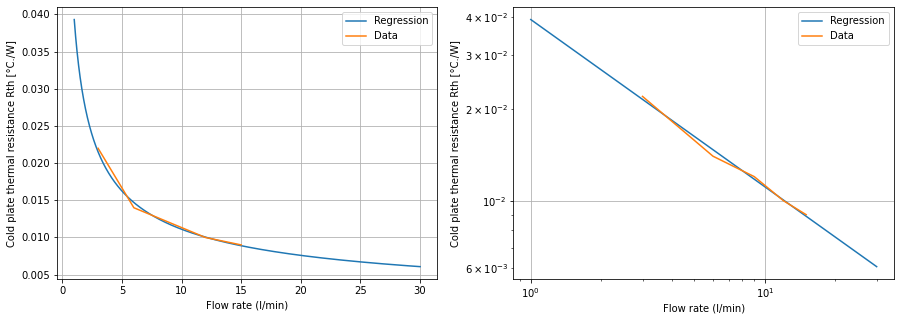

In [15]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

log_Rth_ref = np.log10(Rth_ref).reshape(-1,1)
log_dv_c_ref = np.log10(dvc_ref).reshape(-1,1)

reg.fit(log_dv_c_ref,log_Rth_ref)
β = reg.coef_
logConstant = reg.intercept_
C = 10**logConstant
print("- β = %0.2f" %β)
print("- C = %0.2E" %C)


'''Comparison'''
Rth = []
for i in range(n) :
    Rth = np.append(Rth, C*dvc[i]**(β))

figure = plt.figure(figsize = (15, 5))
fig = figure.add_subplot(1, 2, 1)
fig.plot(dvc, Rth)
fig.plot(dvc_ref, Rth_ref)
fig.set_ylabel('Cold plate thermal resistance Rth [°C./W]')
fig.set_xlabel('Flow rate (l/min)')
fig.legend(('Regression', 'Data'))
fig.grid()

fig = figure.add_subplot(1, 2, 2)
fig.plot(dvc, Rth)
fig.plot(dvc_ref, Rth_ref)
fig.set_ylabel('Cold plate thermal resistance Rth [°C./W]')
fig.set_xlabel('Flow rate (l/min)')
fig.legend(('Regression', 'Data'))
fig.grid()
plt.xscale("log")
plt.yscale("log")

The study has thus shown that $R_{th}=R_{th_{nom}}\big(\frac{\dot{m}}{\dot{m}_{nom}}\big)^{\beta}$ with $\beta = -0.55$

##### 3.1.2 Computation of the cold plate heat capacity

> **Question:** Calculate the thermal capacity of the cold plate.

In [12]:
C_plate = cp_alu*m_plate                       #[J/K] plate heat capacity 

print("- Plate mass : m = %0.3f kg" %m_plate)
print("- Plate heat capacity : C = %0.1f J/K" %C_plate)

- Plate mass : m = 1.096 kg
- Plate heat capacity : C = 983.1 J/K


#### 3.2 Computation of the cold plate pressure drop

The cold plate [datasheet](https://www.microcooling.com/wp-content/uploads/2015/05/CP3009-data-sheet.pdf) provides pressure drop function of flow rate:

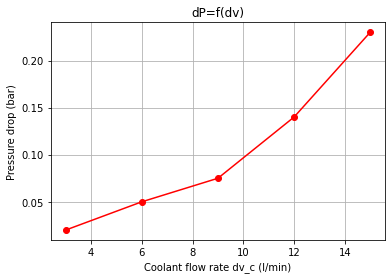

In [16]:
# Data CP3009 Microcool
dPb_ref  = np.array([0.02, 0.05, 0.075, 0.14, 0.23])                   #[bar] pressure drop
dP_ref   = dPb_ref*1e5                                                 #[pressure] pressure drop

plt.plot(dvc_ref, dPb_ref, 'ro-')
plt.ylabel('Pressure drop (bar)')
plt.xlabel('Coolant flow rate dv_c (l/min)')
plt.title('dP=f(dv)')
plt.grid()
plt.show()

> **Question:** We want to define a relation with the following form  
$dP=dP_{nom}\big(\frac{\dot{m}}{\dot{m}_{nom}}\big)^{\gamma} \Longleftrightarrow dP=C\dot{m}^{\gamma}$ with $C$ a constant. <br>
Show how to use linear regression to define this equation. Explain what can be done to improve results. 

In [17]:
# Log transformation
log_dP_ref   = np.log10(dP_ref).reshape(-1,1)
log_dvc_ref = np.log10(dvc_ref).reshape(-1,1)

reg.fit(log_dvc_ref,log_dP_ref)
ɣ    = reg.coef_
logC_lam = reg.intercept_
C    = 10**logC_lam
print("- ɣ = %0.2f" %ɣ)
print("- C = %0.2E" %C)

- ɣ = 1.47
- C = 3.68E+02


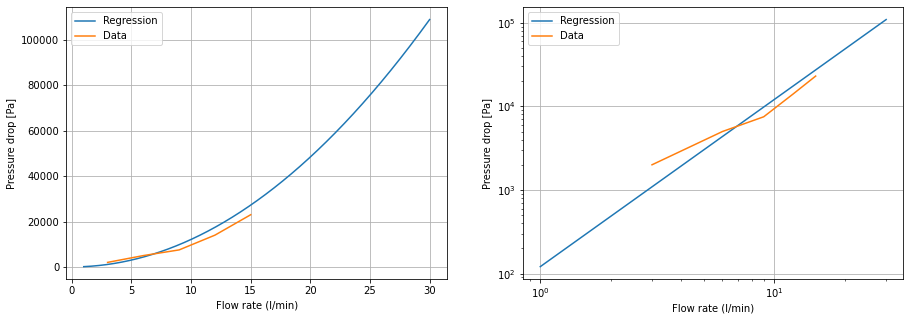

In [18]:
'''Comparison'''
       
figure = plt.figure(figsize = (15, 5))
fig = figure.add_subplot(1, 2, 1)
fig.plot(dvc, dP)
fig.plot(dvc_ref, dP_ref)
fig.set_ylabel('Pressure drop [Pa]')
fig.set_xlabel('Flow rate (l/min)')
fig.legend(('Regression', 'Data'))
fig.grid()

fig = figure.add_subplot(1, 2, 2)
fig.plot(dvc, dP)
fig.plot(dvc_ref, dP_ref)
fig.set_ylabel('Pressure drop [Pa]')
fig.set_xlabel('Flow rate (l/min)')
fig.legend(('Regression', 'Data'))
fig.grid()
plt.xscale("log")
plt.yscale("log")

We can see below that at $\dot{m}=9$ l/min the curve changes suddenly. This must be due to the flow regime that goes from laminar to turbulent. Thus one model is established for each flow regime.